**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
# For PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


**Load Data**

In [3]:
df = pd.read_csv('heart_disease_uci.csv')
print("Data loaded successfully!")
print("Data Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData Types:")
print(df.dtypes)

Data loaded successfully!
Data Shape: (920, 16)

First few rows:
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  

In [4]:
#Checking Unique Values and Identify Categorical Columns
print("="*60)
print("Unique Values per Column:")
for col in df.columns:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count} unique values")
    if unique_count <= 20 and col not in ['id', 'age', 'trestbps', 'chol', 'thalach', 'oldpeak']:
        print(f"  Sample values: {df[col].dropna().unique()[:5]}")

categorical_cols = ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
print(f"\nCategorical columns: {categorical_cols}")

Unique Values per Column:
id: 920 unique values
age: 50 unique values
sex: 2 unique values
  Sample values: ['Male' 'Female']
dataset: 4 unique values
  Sample values: ['Cleveland' 'Hungary' 'Switzerland' 'VA Long Beach']
cp: 4 unique values
  Sample values: ['typical angina' 'asymptomatic' 'non-anginal' 'atypical angina']
trestbps: 61 unique values
chol: 217 unique values
fbs: 2 unique values
  Sample values: [True False]
restecg: 3 unique values
  Sample values: ['lv hypertrophy' 'normal' 'st-t abnormality']
thalch: 119 unique values
exang: 2 unique values
  Sample values: [False True]
oldpeak: 53 unique values
slope: 3 unique values
  Sample values: ['downsloping' 'flat' 'upsloping']
ca: 4 unique values
  Sample values: [0. 3. 2. 1.]
thal: 3 unique values
  Sample values: ['fixed defect' 'normal' 'reversable defect']
num: 5 unique values
  Sample values: [0 2 1 3 4]

Categorical columns: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


In [5]:
#Handle Missing Values

print("\n" + "="*60)
print("Missing values in ALL columns:")
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

# Drop rows with ANY missing values to ensure clean data
df_clean = df.dropna()
print(f"\nShape after dropping ALL rows with missing values: {df_clean.shape}")
print(f"Rows removed: {len(df) - len(df_clean)}")


Missing values in ALL columns:
id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

Total missing values: 1759

Shape after dropping ALL rows with missing values: (299, 16)
Rows removed: 621


In [6]:
#Create Binary Target Variable

df_clean['target'] = (df_clean['num'] > 0).astype(int)
print("\n" + "="*60)
print("Target distribution:")
print(df_clean['target'].value_counts())
print(f"\nClass balance:")
print(df_clean['target'].value_counts(normalize=True))


Target distribution:
target
0    160
1    139
Name: count, dtype: int64

Class balance:
target
0    0.535117
1    0.464883
Name: proportion, dtype: float64


In [7]:
# Drop 'id', 'dataset', 'num', and 'target' columns
X = df_clean.drop(['id', 'dataset', 'num', 'target'], axis=1, errors='ignore')
y = df_clean['target']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")


Features shape: (299, 13)
Target shape: (299,)


In [8]:
#Split Data (60% train, 20% validation, 20% test)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Second split: 75% of temp for train (60% overall), 25% for val (20% overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"\n" + "="*60)
print("Data Split:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(df_clean)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(df_clean)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(df_clean)*100:.1f}%)")



Data Split:
Training set: 179 samples (59.9%)
Validation set: 60 samples (20.1%)
Test set: 60 samples (20.1%)


In [9]:
#One-Hot Encoding with Additional Safety Checks

categorical_cols_to_encode = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"\n" + "="*60)
print(f"Categorical columns to encode: {categorical_cols_to_encode}")

# Check for missing values before encoding
print("\nMissing values in training set before encoding:")
print(X_train.isnull().sum().sum())

# One-hot encode
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols_to_encode, drop_first=True)
X_val_encoded = pd.get_dummies(X_val, columns=categorical_cols_to_encode, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols_to_encode, drop_first=True)

# Align columns
train_cols = X_train_encoded.columns
X_val_encoded = X_val_encoded.reindex(columns=train_cols, fill_value=0)
X_test_encoded = X_test_encoded.reindex(columns=train_cols, fill_value=0)

print(f"\nAfter encoding and alignment:")
print(f"Training: {X_train_encoded.shape}")
print(f"Validation: {X_val_encoded.shape}")
print(f"Test: {X_test_encoded.shape}")

# Final check for NaN values
print("\nChecking for NaN values after encoding:")
print(f"Training NaNs: {X_train_encoded.isnull().sum().sum()}")
print(f"Validation NaNs: {X_val_encoded.isnull().sum().sum()}")
print(f"Test NaNs: {X_test_encoded.isnull().sum().sum()}")

# If any NaNs remain, fill them with 0
if X_train_encoded.isnull().sum().sum() > 0:
    print("\n⚠ Warning: NaN values found! Filling with 0...")
    X_train_encoded = X_train_encoded.fillna(0)
    X_val_encoded = X_val_encoded.fillna(0)
    X_test_encoded = X_test_encoded.fillna(0)

# Convert to numpy arrays (now all should be numeric)
X_train_original = X_train_encoded.astype(float).values
X_val_original = X_val_encoded.astype(float).values
X_test_original = X_test_encoded.astype(float).values
y_train_arr = y_train.values
y_val_arr = y_val.values
y_test_arr = y_test.values

# Final verification
print("\nFinal verification - checking for NaN in numpy arrays:")
print(f"X_train NaNs: {np.isnan(X_train_original).sum()}")
print(f"X_val NaNs: {np.isnan(X_val_original).sum()}")
print(f"X_test NaNs: {np.isnan(X_test_original).sum()}")
print(f"\nData ready for modeling!")


Categorical columns to encode: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

Missing values in training set before encoding:
0

After encoding and alignment:
Training: (179, 18)
Validation: (60, 18)
Test: (60, 18)

Checking for NaN values after encoding:
Training NaNs: 0
Validation NaNs: 0
Test NaNs: 0

Final verification - checking for NaN in numpy arrays:
X_train NaNs: 0
X_val NaNs: 0
X_test NaNs: 0

Data ready for modeling!


In [10]:
#Normalize Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_original)
X_val_scaled = scaler.transform(X_val_original)
X_test_scaled = scaler.transform(X_test_original)

print(f"\n" + "="*60)
print("Normalized data statistics:")
print(f"Train mean: {X_train_scaled.mean():.6f}, std: {X_train_scaled.std():.6f}")
print(f"Val mean: {X_val_scaled.mean():.6f}, std: {X_val_scaled.std():.6f}")
print(f"Test mean: {X_test_scaled.mean():.6f}, std: {X_test_scaled.std():.6f})")


Normalized data statistics:
Train mean: 0.000000, std: 1.000000
Val mean: -0.019649, std: 0.973002
Test mean: -0.064491, std: 1.005304)


In [11]:
#Store Results Dictionary

results = {
    'model': [],
    'normalized': [],
    'train_accuracy': [],
    'val_accuracy': [],
    'test_accuracy': []
}

**(b) Logistic Regression WITHOUT Normalization**

In [12]:
print("\n" + "="*60)
print("STEP B: LOGISTIC REGRESSION (Without Normalization)")
print("="*60)

param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [1000]
}

lr_model = LogisticRegression(random_state=42)
grid_search_lr = GridSearchCV(
    lr_model, param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)

grid_search_lr.fit(X_train_original, y_train_arr)

print(f"\nBest parameters: {grid_search_lr.best_params_}")
print(f"Best CV score: {grid_search_lr.best_score_:.4f}")

best_lr = grid_search_lr.best_estimator_
train_acc_lr = accuracy_score(y_train_arr, best_lr.predict(X_train_original))
val_acc_lr = accuracy_score(y_val_arr, best_lr.predict(X_val_original))
test_acc_lr = accuracy_score(y_test_arr, best_lr.predict(X_test_original))

print(f"\nTrain Accuracy: {train_acc_lr:.4f}")
print(f"Validation Accuracy: {val_acc_lr:.4f}")
print(f"Test Accuracy: {test_acc_lr:.4f}")

results['model'].append('Logistic Regression')
results['normalized'].append('No')
results['train_accuracy'].append(train_acc_lr)
results['val_accuracy'].append(val_acc_lr)
results['test_accuracy'].append(test_acc_lr)



STEP B: LOGISTIC REGRESSION (Without Normalization)
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters: {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV score: 0.8376

Train Accuracy: 0.9106
Validation Accuracy: 0.8333
Test Accuracy: 0.8333


**(c) Logistic Regression WITH Normalization**

In [13]:
print("\n" + "="*60)
print("STEP C: LOGISTIC REGRESSION (With Normalization)")
print("="*60)

lr_model_norm = LogisticRegression(random_state=42)
grid_search_lr_norm = GridSearchCV(
    lr_model_norm, param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)

grid_search_lr_norm.fit(X_train_scaled, y_train_arr)

print(f"\nBest parameters: {grid_search_lr_norm.best_params_}")
print(f"Best CV score: {grid_search_lr_norm.best_score_:.4f}")

best_lr_norm = grid_search_lr_norm.best_estimator_
train_acc_lr_norm = accuracy_score(y_train_arr, best_lr_norm.predict(X_train_scaled))
val_acc_lr_norm = accuracy_score(y_val_arr, best_lr_norm.predict(X_val_scaled))
test_acc_lr_norm = accuracy_score(y_test_arr, best_lr_norm.predict(X_test_scaled))

print(f"\nTrain Accuracy: {train_acc_lr_norm:.4f}")
print(f"Validation Accuracy: {val_acc_lr_norm:.4f}")
print(f"Test Accuracy: {test_acc_lr_norm:.4f}")

results['model'].append('Logistic Regression')
results['normalized'].append('Yes')
results['train_accuracy'].append(train_acc_lr_norm)
results['val_accuracy'].append(val_acc_lr_norm)
results['test_accuracy'].append(test_acc_lr_norm)


STEP C: LOGISTIC REGRESSION (With Normalization)
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters: {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV score: 0.8433

Train Accuracy: 0.8994
Validation Accuracy: 0.8333
Test Accuracy: 0.8333


**(d) Neural Network WITHOUT Normalization**

In [14]:
print("\n" + "="*60)
print("STEP D: NEURAL NETWORK (Without Normalization)")
print("="*60)

param_grid_nn = {
    'hidden_layer_sizes': [
        (50,), (100,), (150,),
        (50, 25), (100, 50), (150, 75), (200, 100)
    ],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [1000]
}

nn_model = MLPClassifier(random_state=42, early_stopping=True, validation_fraction=0.1)
random_search_nn = RandomizedSearchCV(
    nn_model, param_grid_nn, n_iter=30, cv=3, scoring='accuracy',
    n_jobs=-1, verbose=1, random_state=42
)

random_search_nn.fit(X_train_original, y_train_arr)

print(f"\nBest parameters: {random_search_nn.best_params_}")
print(f"Best CV score: {random_search_nn.best_score_:.4f}")

best_nn = random_search_nn.best_estimator_
train_acc_nn = accuracy_score(y_train_arr, best_nn.predict(X_train_original))
val_acc_nn = accuracy_score(y_val_arr, best_nn.predict(X_val_original))
test_acc_nn = accuracy_score(y_test_arr, best_nn.predict(X_test_original))

print(f"\nTrain Accuracy: {train_acc_nn:.4f}")
print(f"Validation Accuracy: {val_acc_nn:.4f}")
print(f"Test Accuracy: {test_acc_nn:.4f}")

results['model'].append('Neural Network (sklearn)')
results['normalized'].append('No')
results['train_accuracy'].append(train_acc_nn)
results['val_accuracy'].append(val_acc_nn)
results['test_accuracy'].append(test_acc_nn)


STEP D: NEURAL NETWORK (Without Normalization)
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best parameters: {'max_iter': 1000, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100,), 'alpha': 0.01, 'activation': 'relu'}
Best CV score: 0.6873

Train Accuracy: 0.7039
Validation Accuracy: 0.7167
Test Accuracy: 0.7000


**(e) Neural Network WITH Normalization**

In [15]:
print("\n" + "="*60)
print("STEP E: NEURAL NETWORK (With Normalization)")
print("="*60)

param_grid_nn = {
    'hidden_layer_sizes': [
        (50,), (100,), (150,),
        (50, 25), (100, 50), (150, 75), (200, 100)
    ],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [1000]
}

nn_model_norm = MLPClassifier(random_state=42, early_stopping=True, validation_fraction=0.1)
random_search_nn_norm = RandomizedSearchCV(
    nn_model_norm, param_grid_nn, n_iter=30, cv=3, scoring='accuracy',
    n_jobs=-1, verbose=1, random_state=42
)

random_search_nn_norm.fit(X_train_scaled, y_train_arr)

print(f"\nBest parameters: {random_search_nn_norm.best_params_}")
print(f"Best CV score: {random_search_nn_norm.best_score_:.4f}")

best_nn_norm = random_search_nn_norm.best_estimator_
train_acc_nn_norm = accuracy_score(y_train_arr, best_nn_norm.predict(X_train_scaled))
val_acc_nn_norm = accuracy_score(y_val_arr, best_nn_norm.predict(X_val_scaled))
test_acc_nn_norm = accuracy_score(y_test_arr, best_nn_norm.predict(X_test_scaled))

print(f"\nTrain Accuracy: {train_acc_nn_norm:.4f}")
print(f"Validation Accuracy: {val_acc_nn_norm:.4f}")
print(f"Test Accuracy: {test_acc_nn_norm:.4f}")

results['model'].append('Neural Network (sklearn)')
results['normalized'].append('Yes')
results['train_accuracy'].append(train_acc_nn_norm)
results['val_accuracy'].append(val_acc_nn_norm)
results['test_accuracy'].append(test_acc_nn_norm)


STEP E: NEURAL NETWORK (With Normalization)
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best parameters: {'max_iter': 1000, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100, 50), 'alpha': 0.0001, 'activation': 'relu'}
Best CV score: 0.8487

Train Accuracy: 0.8547
Validation Accuracy: 0.8667
Test Accuracy: 0.8667


**(f) Define PyTorch Neural Network**

In [16]:
print("\n" + "="*60)
print("STEP F: PYTORCH NEURAL NETWORK")
print("="*60)

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size=None, dropout_rate=0.3):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.bn1 = nn.BatchNorm1d(hidden1_size)
        self.dropout1 = nn.Dropout(dropout_rate)

        if hidden2_size:
            self.fc2 = nn.Linear(hidden1_size, hidden2_size)
            self.bn2 = nn.BatchNorm1d(hidden2_size)
            self.dropout2 = nn.Dropout(dropout_rate)
            self.fc3 = nn.Linear(hidden2_size, 1)
            self.has_hidden2 = True
        else:
            self.fc2 = nn.Linear(hidden1_size, 1)
            self.has_hidden2 = False

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        if self.has_hidden2:
            x = torch.relu(self.bn2(self.fc2(x)))
            x = self.dropout2(x)
            x = torch.sigmoid(self.fc3(x))
        else:
            x = torch.sigmoid(self.fc2(x))

        return x



STEP F: PYTORCH NEURAL NETWORK


**PyTorch Training Function**

In [17]:

def train_pytorch_model(X_train, y_train, X_val, y_val, X_test, y_test,
                        hidden1, hidden2=None, lr=0.001, epochs=200,
                        batch_size=32, dropout=0.3):

    # Convert to tensors
    X_train_t = torch.FloatTensor(X_train)
    y_train_t = torch.FloatTensor(y_train).reshape(-1, 1)
    X_val_t = torch.FloatTensor(X_val)
    y_val_t = torch.FloatTensor(y_val).reshape(-1, 1)
    X_test_t = torch.FloatTensor(X_test)
    y_test_t = torch.FloatTensor(y_test).reshape(-1, 1)

    # Create data loaders
    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize model
    input_size = X_train.shape[1]
    model = NeuralNet(input_size, hidden1, hidden2, dropout)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                      factor=0.5, patience=10) # Removed verbose=False

    best_val_acc = 0
    best_model_state = None
    patience_counter = 0
    patience_limit = 30

    for epoch in range(epochs):
        # Training
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_t)
            val_preds = (val_outputs >= 0.5).float()
            val_acc = (val_preds == y_val_t).float().mean().item()

        scheduler.step(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience_limit:
            break

        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Val Acc: {val_acc:.4f}")

    # Load best model
    model.load_state_dict(best_model_state)

    # Final evaluation
    model.eval()
    with torch.no_grad():
        train_outputs = model(X_train_t)
        train_preds = (train_outputs >= 0.5).float()
        train_acc = (train_preds == y_train_t).float().mean().item()

        val_outputs = model(X_val_t)
        val_preds = (val_outputs >= 0.5).float()
        val_acc = (val_preds == y_val_t).float().mean().item()

        test_outputs = model(X_test_t)
        test_preds = (test_outputs >= 0.5).float()
        test_acc = (test_preds == y_test_t).float().mean().item()

    return model, train_acc, val_acc, test_acc


**PyTorch Hyperparameter Search**

In [18]:
print("\nSearching for best PyTorch architecture...")

# Prioritizing the user-specified configuration
pytorch_configs = [
    {'hidden1': 128, 'hidden2': 64, 'lr': 0.001, 'dropout': 0.3},
]

best_pytorch_val_acc = 0
best_pytorch_model = None
best_pytorch_config = None
best_pytorch_results = None

for i, config in enumerate(pytorch_configs):
    print(f"\n--- Config {i+1}/{len(pytorch_configs)} ---")
    print(f"Hidden layers: {config['hidden1']}", end="")
    if config['hidden2']:
        print(f", {config['hidden2']}")
    else:
        print()

    model, train_acc, val_acc, test_acc = train_pytorch_model(
        X_train_scaled, y_train_arr, X_val_scaled, y_val_arr,
        X_test_scaled, y_test_arr, **config
    )

    print(f"Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}")

    if val_acc > best_pytorch_val_acc:
        best_pytorch_val_acc = val_acc
        best_pytorch_model = model
        best_pytorch_config = config
        best_pytorch_results = (train_acc, val_acc, test_acc)

# If only one config is run, the results are the best results
if len(pytorch_configs) == 1:
     best_pytorch_config = pytorch_configs[0]
     best_pytorch_results = (train_acc, val_acc, test_acc)


print("\n" + "="*60)
print("Best PyTorch Configuration:")
print(f"Config: {best_pytorch_config}")
print(f"Train Accuracy: {best_pytorch_results[0]:.4f}")
print(f"Validation Accuracy: {best_pytorch_results[1]:.4f}")
print(f"Test Accuracy: {best_pytorch_results[2]:.4f}")

results['model'].append('Neural Network (PyTorch)')
results['normalized'].append('Yes')
results['train_accuracy'].append(best_pytorch_results[0])
results['val_accuracy'].append(best_pytorch_results[1])
results['test_accuracy'].append(best_pytorch_results[2])



Searching for best PyTorch architecture...

--- Config 1/1 ---
Hidden layers: 128, 64
Train: 0.9497, Val: 0.8333, Test: 0.8333

Best PyTorch Configuration:
Config: {'hidden1': 128, 'hidden2': 64, 'lr': 0.001, 'dropout': 0.3}
Train Accuracy: 0.9497
Validation Accuracy: 0.8333
Test Accuracy: 0.8333


**(g) Compare All Models**

In [19]:
print("\n" + "="*60)
print("FINAL COMPARISON OF ALL MODELS")
print("="*60)

results_df = pd.DataFrame(results)
results_df['test_accuracy_pct'] = results_df['test_accuracy'] * 100

print("\nResults Table:")
print(results_df.to_string(index=False))

print("\n" + "="*60)
print("BEST MODEL BY TEST ACCURACY:")
best_idx = results_df['test_accuracy'].idxmax()
best_model = results_df.loc[best_idx]
print(f"Model: {best_model['model']}")
print(f"Normalized: {best_model['normalized']}")
print(f"Test Accuracy: {best_model['test_accuracy']:.4f} ({best_model['test_accuracy_pct']:.2f}%)")
print("="*60)

# Check if we met the 85% threshold
if best_model['test_accuracy'] >= 0.85:
    print(f"\n✓ SUCCESS! Achieved {best_model['test_accuracy_pct']:.2f}% test accuracy (≥85% required)")
else:
    print(f"\n✗ WARNING: Best test accuracy is {best_model['test_accuracy_pct']:.2f}% (<85% required)")



FINAL COMPARISON OF ALL MODELS

Results Table:
                   model normalized  train_accuracy  val_accuracy  test_accuracy  test_accuracy_pct
     Logistic Regression         No        0.910615      0.833333       0.833333          83.333333
     Logistic Regression        Yes        0.899441      0.833333       0.833333          83.333333
Neural Network (sklearn)         No        0.703911      0.716667       0.700000          70.000000
Neural Network (sklearn)        Yes        0.854749      0.866667       0.866667          86.666667
Neural Network (PyTorch)        Yes        0.949721      0.833333       0.833333          83.333331

BEST MODEL BY TEST ACCURACY:
Model: Neural Network (sklearn)
Normalized: Yes
Test Accuracy: 0.8667 (86.67%)

✓ SUCCESS! Achieved 86.67% test accuracy (≥85% required)


**Visualization of Results**

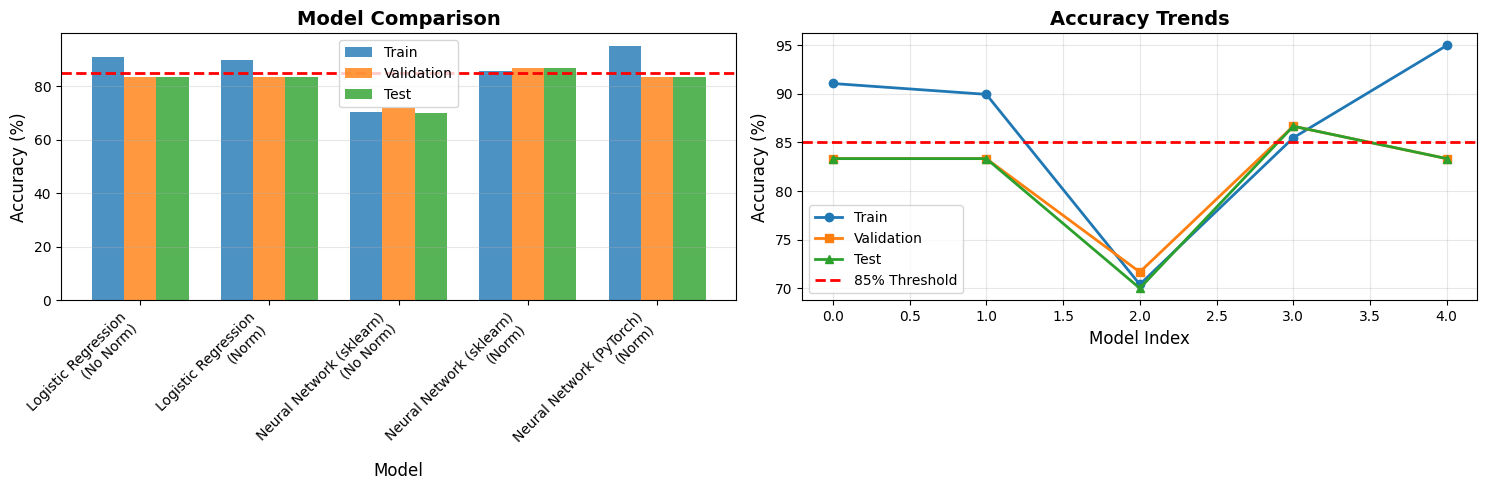


✓ Visualization saved as 'model_comparison.png'


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
x_pos = np.arange(len(results_df))
width = 0.25

axes[0].bar(x_pos - width, results_df['train_accuracy']*100, width, label='Train', alpha=0.8)
axes[0].bar(x_pos, results_df['val_accuracy']*100, width, label='Validation', alpha=0.8)
axes[0].bar(x_pos + width, results_df['test_accuracy']*100, width, label='Test', alpha=0.8)

axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Model Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f"{m}\n({'Norm' if n=='Yes' else 'No Norm'})"
                          for m, n in zip(results_df['model'], results_df['normalized'])],
                         rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].axhline(y=85, color='r', linestyle='--', linewidth=2, label='85% Threshold')

# Line plot
axes[1].plot(results_df.index, results_df['train_accuracy']*100, marker='o', label='Train', linewidth=2)
axes[1].plot(results_df.index, results_df['val_accuracy']*100, marker='s', label='Validation', linewidth=2)
axes[1].plot(results_df.index, results_df['test_accuracy']*100, marker='^', label='Test', linewidth=2)
axes[1].axhline(y=85, color='r', linestyle='--', linewidth=2, label='85% Threshold')

axes[1].set_xlabel('Model Index', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Accuracy Trends', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'model_comparison.png'")

**Detailed Analysis of Best Model**


DETAILED ANALYSIS OF BEST MODEL

Best Model: Neural Network (sklearn) (with normalization)

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.85      0.91      0.88        32
     Disease       0.88      0.82      0.85        28

    accuracy                           0.87        60
   macro avg       0.87      0.86      0.87        60
weighted avg       0.87      0.87      0.87        60



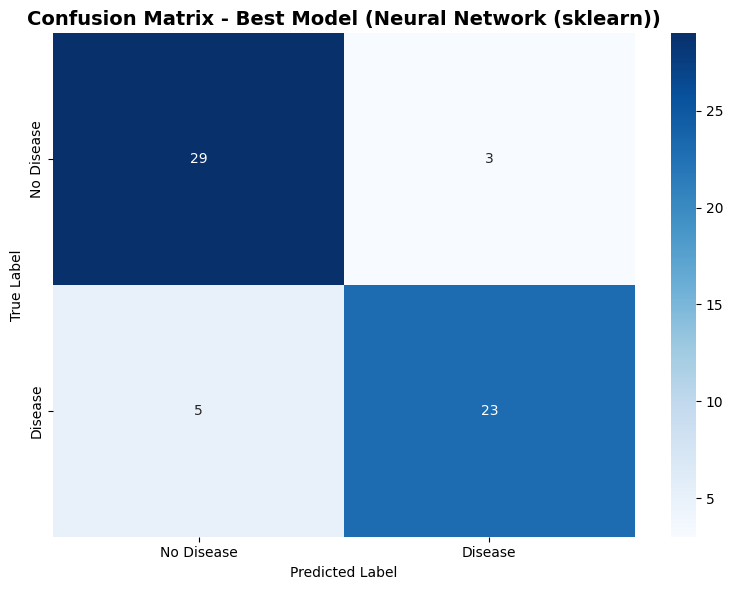


✓ Analysis complete! Confusion matrix saved.


In [21]:
print("\n" + "="*60)
print("DETAILED ANALYSIS OF BEST MODEL")
print("="*60)

if best_model['model'] == 'Neural Network (PyTorch)':
    print("\nBest Model: PyTorch Neural Network")
    print(f"Architecture: {best_pytorch_config}")

    # Get predictions
    best_pytorch_model.eval()
    with torch.no_grad():
        test_preds = (best_pytorch_model(torch.FloatTensor(X_test_scaled)) >= 0.5).float().numpy()

    print("\nClassification Report:")
    print(classification_report(y_test_arr, test_preds,
                                target_names=['No Disease', 'Disease']))

    # Confusion Matrix
    cm = confusion_matrix(y_test_arr, test_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Disease', 'Disease'],
                yticklabels=['No Disease', 'Disease'])
    plt.title('Confusion Matrix - Best Model (PyTorch)', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_best_model.png', dpi=300, bbox_inches='tight')
    plt.show()

else:
    # For sklearn models
    if 'Logistic' in best_model['model']:
        if best_model['normalized'] == 'Yes':
            best_sklearn_model = best_lr_norm
            X_test_use = X_test_scaled
        else:
            best_sklearn_model = best_lr
            X_test_use = X_test_original
    else:  # Neural Network sklearn
        if best_model['normalized'] == 'Yes':
            best_sklearn_model = best_nn_norm
            X_test_use = X_test_scaled
        else:
            best_sklearn_model = best_nn
            X_test_use = X_test_original

    test_preds = best_sklearn_model.predict(X_test_use)

    print(f"\nBest Model: {best_model['model']} ({'with' if best_model['normalized']=='Yes' else 'without'} normalization)")
    print("\nClassification Report:")
    print(classification_report(y_test_arr, test_preds,
                                target_names=['No Disease', 'Disease']))

    cm = confusion_matrix(y_test_arr, test_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Disease', 'Disease'],
                yticklabels=['No Disease', 'Disease'])
    plt.title(f'Confusion Matrix - Best Model ({best_model["model"]})',
              fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_best_model.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n✓ Analysis complete! Confusion matrix saved.")